In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import igpu
import cupy as cp
import pickle

In [3]:
mice = ["mpfc14", "mpfc19", "mpfc20", "mpfc23", "mpfc24"]
days = ["yd1", "yd2", "yd6"]

In [15]:
x = []
for mi, mouse in enumerate(mice):
    xs = []
    for di, day in enumerate(days):
        xs.append(pd.read_csv(mouse + "/" + mouse + "_" + day + ".csv", header=None).values)
    x.append(xs)

In [5]:
beh = []
for mi, mouse in enumerate(mice):
    behs = []
    for di, day in enumerate(days):
        df = pd.read_csv("behavior/" + mouse + "/" +mouse + "_" + day + ".csv", header=None).values
        
        n = len(df[:, 0])
        t = np.zeros(n)
        for i in range(1, n-1):
            if df[i, 0] == 1:
                t[i] = 1
            else:
                if df[i-1, 0] == 1 and df[i+1, 0] == 1:
                    t[i] = 1
        df[:, 0] = t.copy()
        
        # remove "just-in-case" lick
        count = 0
        for i in range(n):
            if df[i, 2] == 1:
                count = 0
            elif df[i, 1] == 1:
                if count < 50:
                    df[i, 1] = 0
                count = 0
            else:
                count += 1
                
        behs.append(df)
    beh.append(behs)

In [6]:
with open("h_single_Wlim001.pkl", "rb") as f:
    h = pickle.load(f)
with open("w_single_Wlim001.pkl", "rb") as f:
    w = pickle.load(f)

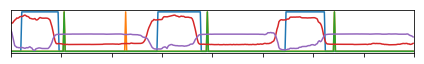

In [182]:
mi = 4
di = 2
start = 950
plt.figure(figsize=(6, 1))
plt.plot(beh[mi][di][start:start+400, :5])
plt.xlim(0, 400)
plt.tick_params(left=False, labelleft=False, labelbottom=False)
plt.tight_layout()
plt.savefig("paper/fig2/fig2gh_top.png")

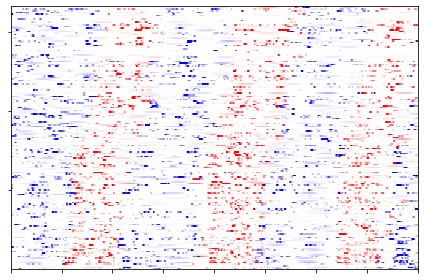

In [22]:
wi = 1
u = cp.asnumpy(igpu.single.conv_single(
    cp.array(w[mi][di][wi][:, 0][:, cp.newaxis]),
    cp.array(w[mi][di][wi][:, 1][:, cp.newaxis]),
    cp.array(h[mi][di][start:start+449, wi:wi+1]).T, 50, 1e-7)).T
tmp = x[mi][di][start:start+400].copy()
max_val = tmp.mean() + 3 * tmp.std()
tmp[tmp > max_val] = max_val
tmp[u < u.mean()] *= -1
tmp /= max_val
index = np.arange(tmp.shape[1])
tmp_sort = np.sort(w[mi][di][wi][:, 0])[::-1]
th = tmp_sort[np.where(np.cumsum(tmp_sort) > 0.9)[0].min()]
b = w[mi][di][wi][:, 0] > th
tmp = tmp[:, index[b][w[mi][di][wi][b, 1].argsort()]].T
plt.figure(figsize=(6, 4))
plt.pcolor(tmp, vmin=-1, vmax=1, cmap="bwr")
plt.xticks([50*i for i in range(9)])
plt.yticks([50, 100, 150])
plt.tick_params(labelleft=False, labelbottom=False)
plt.tight_layout()
plt.savefig("paper/fig2/fig2h_right.png")

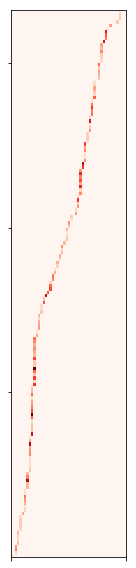

In [181]:
th = tmp_sort[np.where(np.cumsum(tmp_sort) > 0.9)[0].min()]
b = w[mi][di][wi][:, 0] > th
id_sig = index[b][w[mi][di][wi][b, 1].argsort()]
n_sig = len(id_sig)
tmp = np.zeros((n_sig, 50))
for ii, i in enumerate(id_sig):
    tmp[ii, int(w[mi][di][wi][i, 1])] = w[mi][di][wi][i, 0]
plt.figure(figsize=(2, 8))
plt.pcolor(tmp, vmin=0, vmax=w[mi][di][wi][id_sig, 0].mean() + 3 * w[mi][di][wi][id_sig, 0].std(), cmap="Reds")
plt.xticks([0, 50])
plt.yticks([50, 100, 150])
plt.tick_params(labelleft=False, labelbottom=False)
plt.tight_layout()
plt.savefig("paper/fig2/fig2h_left.png")

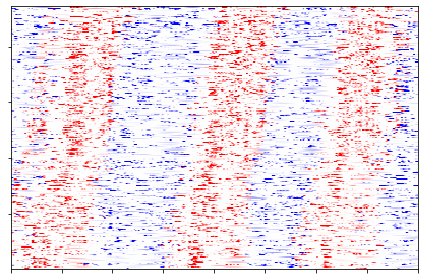

In [23]:
wi = 4
u = cp.asnumpy(igpu.single.conv_single(
    cp.array(w[mi][di][wi][:, 0][:, cp.newaxis]),
    cp.array(w[mi][di][wi][:, 1][:, cp.newaxis]),
    cp.array(h[mi][di][start:start+449, wi:wi+1]).T, 50, 1e-7)).T
tmp = x[mi][di][start:start+400].copy()
max_val = tmp.mean() + 3 * tmp.std()
tmp[tmp > max_val] = max_val
tmp[u < u.mean()] *= -1
tmp /= max_val
index = np.arange(tmp.shape[1])
tmp_sort = np.sort(w[mi][di][wi][:, 0])[::-1]
th = tmp_sort[np.where(np.cumsum(tmp_sort) > 0.9)[0].min()]
b = w[mi][di][wi][:, 0] > th
tmp = tmp[:, index[b][w[mi][di][wi][b, 1].argsort()]].T
plt.figure(figsize=(6, 4))
plt.pcolor(tmp, vmin=-1, vmax=1, cmap="bwr")
plt.xticks([50*i for i in range(9)])
plt.yticks([50, 100, 150, 200])
plt.tick_params(labelleft=False, labelbottom=False)
plt.tight_layout()
plt.savefig("paper/fig2/fig2g2_right.png")

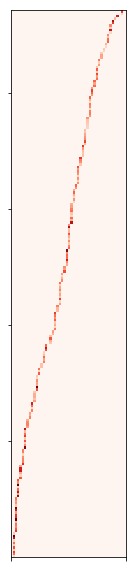

In [186]:
th = tmp_sort[np.where(np.cumsum(tmp_sort) > 0.9)[0].min()]
b = w[mi][di][wi][:, 0] > th
id_sig = index[b][w[mi][di][wi][b, 1].argsort()]
n_sig = len(id_sig)
tmp = np.zeros((n_sig, 50))
for ii, i in enumerate(id_sig):
    tmp[ii, int(w[mi][di][wi][i, 1])] = w[mi][di][wi][i, 0]
plt.figure(figsize=(2, 8))
plt.pcolor(tmp, vmin=0, vmax=w[mi][di][wi][id_sig, 0].mean() + 3 * w[mi][di][wi][id_sig, 0].std(), cmap="Reds")
plt.xticks([0, 50])
plt.yticks([50, 100, 150, 200])
plt.tick_params(labelleft=False, labelbottom=False)
plt.tight_layout()
plt.savefig("paper/fig2/fig2g_left.png")

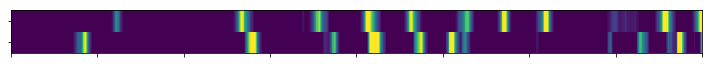

In [43]:
plt.figure(figsize=(10, 1))
tmp = (h[mi][di][100+49:2100+49, [1, 4]] - h[mi][di][100+49:2100+49, [1, 4]].mean(axis=0)) / h[mi][di][100+49:2100+49, [1, 4]].std(axis=0)
plt.pcolor(tmp.T, vmin=0, vmax=3)
plt.yticks([0.5, 1.5])
plt.xticks([250*i for i in range(9)])
mp = plt.tick_params(labelleft=False, labelbottom=False)
plt.tight_layout()
plt.savefig("paper/fig2/fig2i.png")

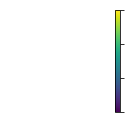

In [53]:
plt.figure(figsize=(2, 2))
mp = plt.pcolor([[]], vmin=0, vmax=3)
plt.axis("off")
cb = plt.colorbar(mp, ticks=[0, 1, 2, 3])
cb.ax.set_yticklabels(["" for _ in range(4)])
plt.tight_layout()
plt.savefig("paper/fig2/fig2i_colorbar.png")